# Download Required Dependencies

In [1]:
import subprocess
import sys
import os
# Function to install a package using pip
def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# List of required packages
required_packages = [
    "scikit-learn",
    "scikit-image",
    "numpy",
    "matplotlib",
    "roboflow",
    "pandas",
]

# Check and install each package
for package in required_packages:
    try:
        __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        install_package(package)

Installing scikit-learn...
Installing scikit-image...


# Import Required Dependencies

In [2]:
from skimage.io import imread, imshow
# from skimage.transform import resize
import skimage
from skimage.color import rgb2gray
from skimage import exposure
import pandas as pd
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler


# Import and preprocess dataset

In [3]:
import os
import cv2
import numpy as np
import pandas as pd 

# Pre-define parameters
input_image_shape = (64, 160)

# Import dataset
dataset_folder = "./INRIA_Person_detection_dataset"
dataset_name_list = ["train", "test", "valid"]
data_folder = "./data"
pre_X = {}
pre_y = {}
X = {}
y = {}
for dataset_name in dataset_name_list:
    dataset_path = os.path.join(dataset_folder, dataset_name)
    annotations_path = os.path.join(dataset_path, "_annotations.csv")
    annotations = pd.read_csv(annotations_path)
    pre_X[dataset_name] = []
    pre_y[dataset_name] = []
    for index, row in annotations.iterrows():
        input_image = cv2.imread(os.path.join(dataset_path, row["filename"]))
        cropped_image = input_image[row["ymin"]: row["ymax"], row["xmin"]: row["xmax"], :]
        gray_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
        pre_X[dataset_name].append(gray_image)
        pre_y[dataset_name].append(1 if row["class"]=="person" else 0)

# Preprocess dataset
X_train, X_valid, X_test, y_train, y_valid, y_test = [], [], [], [], [], []

for image in pre_X['train']:
    resized_image = cv2.resize(image, input_image_shape)
    X_train.append(resized_image)
X_train = np.array(X_train)
y_train = np.array(pre_y['train'])

for image in pre_X['valid']:
    resized_image = cv2.resize(image, input_image_shape)
    X_valid.append(resized_image)
X_valid = np.array(X_valid)
y_valid = np.array(pre_y['valid'])

for image in pre_X['test']:
    resized_image = cv2.resize(image, input_image_shape)
    X_test.append(resized_image)
X_test = np.array(X_test)
y_test = np.array(pre_y['test'])

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(2124, 160, 64) (2124,)
(725, 160, 64) (725,)
(361, 160, 64) (361,)


# Helper functions

In [43]:
import os

def features_available(name, dataset_name_list=['train', 'test', 'valid']):
    data_folder = './data'

    for dataset_name in dataset_name_list:
        features_path = os.path.join(os.path.join(data_folder, 'extracted_features'), dataset_name)
        features_path = os.path.join(features_path, name + '_features.npy')
        if not(os.path.exists(features_path)):
            return False
    return True

In [16]:
import os
import numpy as np

def load_features(name, dataset_name):
    data_folder = "./data"
    features_path = os.path.join(data_folder, "extracted_features")
    features_path = os.path.join(features_path, dataset_name)
    features_path = os.path.join(features_path, name + "_features.npy")
    
    return np.load(features_path, allow_pickle=True)

In [17]:
import os
import numpy as np

def save_features(name, dataset_name, features):
    data_folder = "./data"
    if not(os.path.exists(data_folder)):
        os.mkdir(data_folder)
    features_path = os.path.join(data_folder, "extracted_features")
    if not(os.path.exists(features_path)):
        os.mkdir(features_path)
    features_path = os.path.join(features_path, dataset_name)
    if not(os.path.exists(features_path)):
        os.mkdir(features_path)
    features_path = os.path.join(features_path, name + "_features")
    
    np.save(features_path, features)
    

# Histogram of oriented gradients (HOG)

## Visualize HOG features on Test Image

Text(0.5, 1.0, 'Histogram of Oriented Gradients')

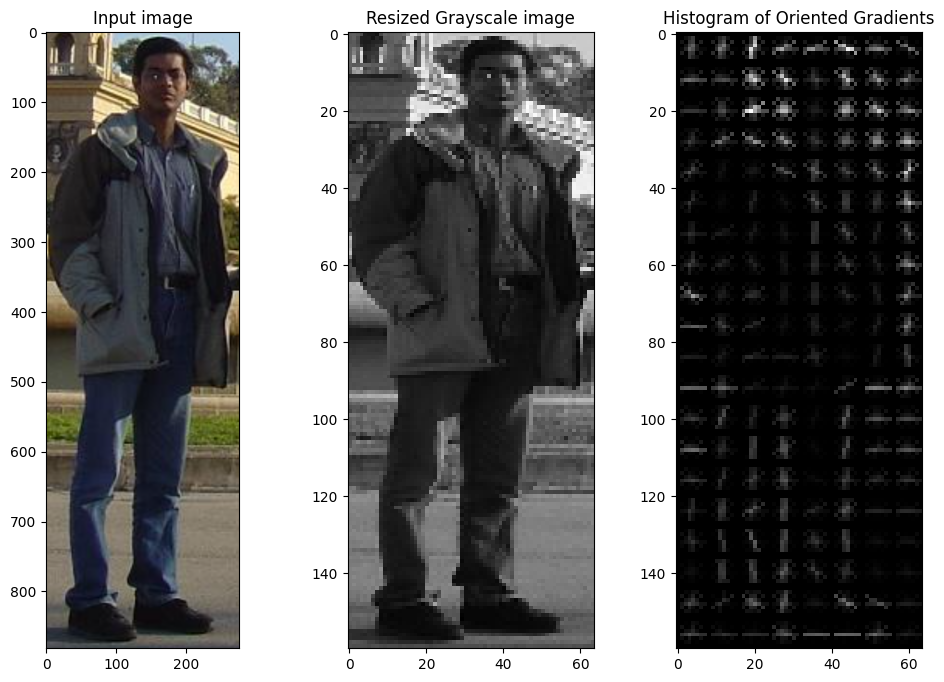

In [54]:
from skimage.feature import hog
import matplotlib.pyplot as plt

test_image = cv2.cvtColor(cv2.imread(os.path.join('./media/test_image.png')), cv2.COLOR_BGR2RGB)
test_image_resized = cv2.resize(test_image, input_image_shape)
test_image_resized_gray = cv2.cvtColor(test_image_resized, cv2.COLOR_RGB2GRAY)

fd, hog_image = hog(test_image_resized_gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 8))
ax1.imshow(test_image)
ax1.set_title('Input image')

ax2.imshow(test_image_resized_gray, cmap=plt.cm.gray)
ax2.set_title('Resized Grayscale image') 

ax3.imshow(hog_image, cmap=plt.cm.gray)
ax3.set_title('Histogram of Oriented Gradients') 

## Define HOG transformer

In [55]:
from skimage.feature import hog
import numpy as np

class HOG_transfomer():
    def __init__(self, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block

    def transform(self, X):
        transformed_X = []
        list_histogram = [] 

        for image in X:
            histogram, hog_image = hog(image, orientations=self.orientations, pixels_per_cell=self.pixels_per_cell, cells_per_block=self.cells_per_block, visualize=True)
            transformed_X.append(hog_image)
            list_histogram.append(histogram)
        return np.array(list_histogram), np.array(transformed_X)
    

## Extract HOG features from datasets

In [56]:
import numpy as np
from skimage.feature import hog

resave = False

features_train, features_valid, features_test = [], [], []

if resave or not features_available('HOG'):
    features_train, features_valid, features_test = [], [], []
    hog_transformer = HOG_transfomer()

    features_train, _ = hog_transformer.transform(X_train)
    features_valid, _ = hog_transformer.transform(X_valid)
    features_test, _ = hog_transformer.transform(X_test)

    save_features('HOG', 'train', features_train)
    save_features('HOG', 'valid', features_valid)
    save_features('HOG', 'test', features_test)

features_train = load_features('HOG', 'train')
features_valid = load_features('HOG', 'valid')
features_test = load_features('HOG', 'test')

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)


(2124, 4788)
(725, 4788)
(361, 4788)


## Train classifiers based on HOG Features

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf_hog = RandomForestClassifier()
rf_hog.fit(features_train, y_train)

y_pred = rf_hog.predict(features_test)
test_report = classification_report(y_test, y_pred)
print(test_report)

              precision    recall  f1-score   support

           0       0.98      0.88      0.92       186
           1       0.88      0.98      0.93       175

    accuracy                           0.93       361
   macro avg       0.93      0.93      0.93       361
weighted avg       0.93      0.93      0.93       361



In [58]:
from sklearn import svm
from sklearn.metrics import classification_report

svc_hog = svm.SVC()
svc_hog.fit(features_train, y_train)
y_pred = svc_hog.predict(features_test)

test_report = classification_report(y_test, y_pred)
print(test_report)

              precision    recall  f1-score   support

           0       0.99      0.92      0.96       186
           1       0.93      0.99      0.96       175

    accuracy                           0.96       361
   macro avg       0.96      0.96      0.96       361
weighted avg       0.96      0.96      0.96       361



# Extended center-symmetric local binary pattern (XCS-LBP)

## Define XCS-LBP transformer

In [ ]:
import math
import numpy as np

class XCS_LBP_transformer():
    def __init__(self, n_points=8, radius=1):
        self.n_points = n_points
        self.radius = radius
        
    def calculate_XCS_LBP_value(self, x, y, image):
        g = self.__calculate_neighbors(x, y, image)
        XCS_LBP_value = 0
        for i in range(int(self.n_points/2)):
            g1 = g[i] - g[i+int(self.n_points/2)] + image[x, y]
            g2 = (g[i] - image[x, y])*(g[i+int(self.n_points/2)] - image[x, y])
            XCS_LBP_value += self.__threshold_function(g1 + g2) * (1 << i)
        return XCS_LBP_value
        
    def __calculate_neighbors(self, x, y, image):
        neighbors = [0 for _ in range(self.n_points)]
        angle_jump = 360 / self.n_points
        for i in range(self.n_points):
            angle = angle_jump * i - 90
            angle_rad = math.radians(angle)
            # Coordinates of the neighboring cell
            new_x = x + self.radius * math.cos(angle_rad)
            new_y = y - self.radius * math.sin(angle_rad)
            neighbors[i] = self.__bilinear_interpolation(new_x, new_y, image)
        return neighbors
        
    def __bilinear_interpolation(self, x, y, image):
        # Fractional part of the coordinates
        dx = x - math.floor(x)
        dy = y - math.floor(y)
        
        x_1 = math.floor(x)
        y_1 = math.floor(y)
        x_2 = math.ceil(x)
        y_2 = math.ceil(y)

        top_left_value = self.__get_cell_value(x_1, y_1, image)
        top_right_value = self.__get_cell_value(x_2, y_1, image)
        bottom_left_value = self.__get_cell_value(x_1, y_2, image)
        bottom_right_value = self.__get_cell_value(x_2, y_2, image)
        result = top_left_value*(1-dx)*(1-dy) + top_right_value*dx*(1-dy) + bottom_left_value*(1-dx)*dy + bottom_right_value*dx*dy
        return result
        
    def __get_cell_value(self, x, y, image):
        if (x >= 0 and y >= 0 and x < image.shape[0] and y < image.shape[1]):
            return image[x, y]
        else:
            return 0

    def __threshold_function(self, x):
        return 1 if x >= 0 else 0

        
    def transform(self, X):
        transformed_X = []
        list_histogram = [] 

        for image in X:
            XCS_LBP_image = image.copy()
            histogram = np.array([0 for _ in range(1 << int(self.n_points/2))])
            for i in range(XCS_LBP_image.shape[0]):
                for j in range(XCS_LBP_image.shape[1]):
                    XCS_LBP_image[i, j] = self.calculate_XCS_LBP_value(i, j, image)
                    histogram[XCS_LBP_image[i, j]] += 1
            transformed_X.append(XCS_LBP_image)
            list_histogram.append(histogram)
        return np.array(list_histogram), np.array(transformed_X)


## Visualize XCS-LBP Features on Test Image

Text(0.5, 1.0, 'Histogram')

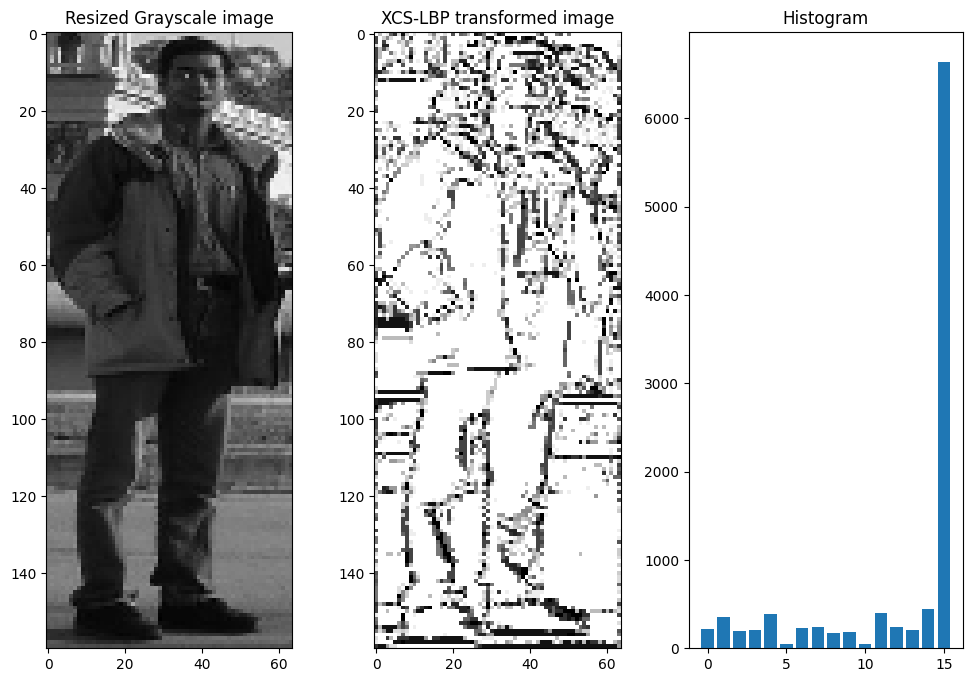

In [12]:
import cv2
import matplotlib.pyplot as plt

test_image = cv2.cvtColor(cv2.imread(os.path.join('./media/test_image.png')), cv2.COLOR_BGR2RGB)
test_image_resized = cv2.resize(test_image, input_image_shape)
test_image_resized_gray = cv2.cvtColor(test_image_resized, cv2.COLOR_RGB2GRAY)

transformer = XCS_LBP_transformer()
histogram, transformed_test_image = transformer.transform([test_image_resized_gray])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 8))

ax1.imshow(test_image_resized_gray, cmap=plt.cm.gray)
ax1.set_title('Resized Grayscale image')

ax2.imshow(transformed_test_image[0], cmap=plt.cm.gray)
ax2.set_title('XCS-LBP transformed image') 

ax3.bar([temp for temp in range(len(histogram[0]))], height=histogram[0])
ax3.set_title('Histogram')

## Extract XCS-LBP features from datasets

In [ ]:
import numpy as np

resave = False

features_train, features_valid, features_test = [], [], []

if resave or not features_available('XCS-LBP'):
    transformer = XCS_LBP_transformer()

    features_train, _ = transformer.transform(X_train)
    features_train = np.array(features_train)

    features_valid, _ = transformer.transform(X_valid)
    features_valid = np.array(features_valid)

    features_test, _ = transformer.transform(X_test)
    features_test = np.array(features_test)

    save_features('XCS-LBP', 'train', features_train)
    save_features('XCS-LBP', 'valid', features_valid)
    save_features('XCS-LBP', 'test', features_test)

features_train = load_features('XCS-LBP', 'train')
features_valid = load_features('XCS-LBP', 'valid')
features_test = load_features('XCS-LBP', 'test')

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)


(2124, 16)
(725, 16)
(361, 16)


## Train classifiers based on XCS-LBP Features

In [ ]:
from sklearn import svm
from sklearn.metrics import classification_report

svc_xcs_lbp = svm.SVC(kernel='linear')

svc_xcs_lbp.fit(features_train, y_train)
y_pred = svc_xcs_lbp.predict(features_test)

test_report = classification_report(y_test, y_pred)
print(test_report)

              precision    recall  f1-score   support

           0       0.90      0.81      0.85       186
           1       0.82      0.91      0.86       175

    accuracy                           0.86       361
   macro avg       0.86      0.86      0.86       361
weighted avg       0.86      0.86      0.86       361



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf_xcs_lbp = RandomForestClassifier()
rf_xcs_lbp.fit(features_train, y_train)
y_pred = rf_xcs_lbp.predict(features_test)

test_report = classification_report(y_test, y_pred)
print(test_report)

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       186
           1       0.91      0.93      0.92       175

    accuracy                           0.92       361
   macro avg       0.92      0.92      0.92       361
weighted avg       0.92      0.92      0.92       361



# Local binary pattern (LBP)

## Define LBP transformer

In [48]:
import numpy as np
from skimage.feature import local_binary_pattern

class LBP_transformer():
    def __init__(self, n_points=8, radius=1):
        self.n_points = n_points
        self.radius = radius

    def transform(self, X):
        transformed_X = []
        list_histogram = []
        for image in X:
            LBP_image = local_binary_pattern(image, self.n_points, self.radius)
            histogram = np.array([0 for _ in range(1 << int(self.n_points))])
            for i in range(LBP_image.shape[0]):
                for j in range(LBP_image.shape[1]):
                    histogram[int(LBP_image[i, j])] += 1
            transformed_X.append(LBP_image)
            list_histogram.append(histogram)

        return np.array(list_histogram), np.array(transformed_X)


## Visualize LBP Features on Test Image

Text(0.5, 1.0, 'Histogram')

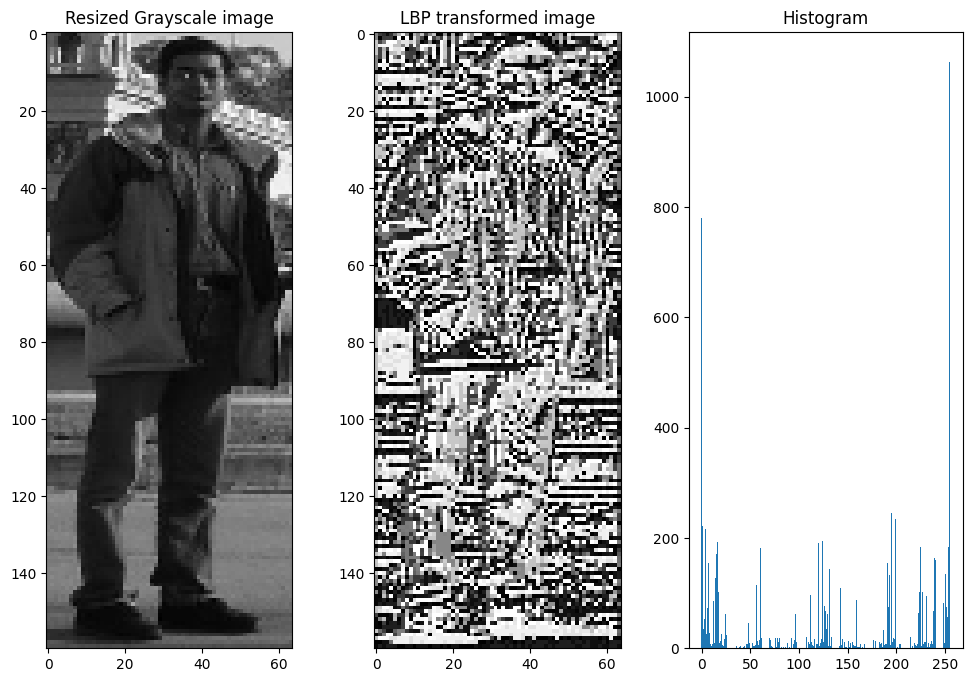

In [25]:
from skimage.feature import local_binary_pattern
import cv2
import matplotlib.pyplot as plt

test_image = cv2.cvtColor(cv2.imread(os.path.join('./media/test_image.png')), cv2.COLOR_BGR2RGB)
test_image_resized = cv2.resize(test_image, input_image_shape)
test_image_resized_gray = cv2.cvtColor(test_image_resized, cv2.COLOR_RGB2GRAY)

transformer = LBP_transformer()
histogram, transformed_test_image = transformer.transform([test_image_resized_gray])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 8))

ax1.imshow(test_image_resized_gray, cmap=plt.cm.gray)
ax1.set_title('Resized Grayscale image')

ax2.imshow(transformed_test_image[0], cmap=plt.cm.gray)
ax2.set_title('LBP transformed image') 

ax3.bar([temp for temp in range(len(histogram[0]))], height=histogram[0])
ax3.set_title('Histogram')

## Extract LBP features from datasets

In [49]:
import numpy as np

resave = True

features_train, features_valid, features_test = [], [], []

if resave or not features_available('LBP'):
    transformer = LBP_transformer()

    features_train, _ = transformer.transform(X_train)
    features_train = np.array(features_train)

    features_valid, _ = transformer.transform(X_valid)
    features_valid = np.array(features_valid)

    features_test, _ = transformer.transform(X_test)
    features_test = np.array(features_test)

    save_features('LBP', 'train', features_train)
    save_features('LBP', 'valid', features_valid)
    save_features('LBP', 'test', features_test)

features_train = load_features('LBP', 'train')
features_valid = load_features('LBP', 'valid')
features_test = load_features('LBP', 'test')

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)


(2124, 256)
(725, 256)
(361, 256)


## Train classifiers based on LBP Features

In [50]:
from sklearn import svm
from sklearn.metrics import classification_report

svc_lbp = svm.SVC(kernel='linear')

svc_lbp.fit(features_train, y_train)
y_pred = svc_lbp.predict(features_test)

test_report = classification_report(y_test, y_pred)
print(test_report)

              precision    recall  f1-score   support

           0       0.85      0.82      0.84       186
           1       0.81      0.85      0.83       175

    accuracy                           0.83       361
   macro avg       0.83      0.83      0.83       361
weighted avg       0.83      0.83      0.83       361



In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf_lbp = RandomForestClassifier()
rf_lbp.fit(features_train, y_train)
y_pred = rf_lbp.predict(features_test)

test_report = classification_report(y_test, y_pred)
print(test_report)

              precision    recall  f1-score   support

           0       0.97      0.80      0.87       186
           1       0.82      0.97      0.89       175

    accuracy                           0.88       361
   macro avg       0.89      0.88      0.88       361
weighted avg       0.89      0.88      0.88       361



# Speeded up robust features (SURF)

## Visualize SURF Features on Test Image

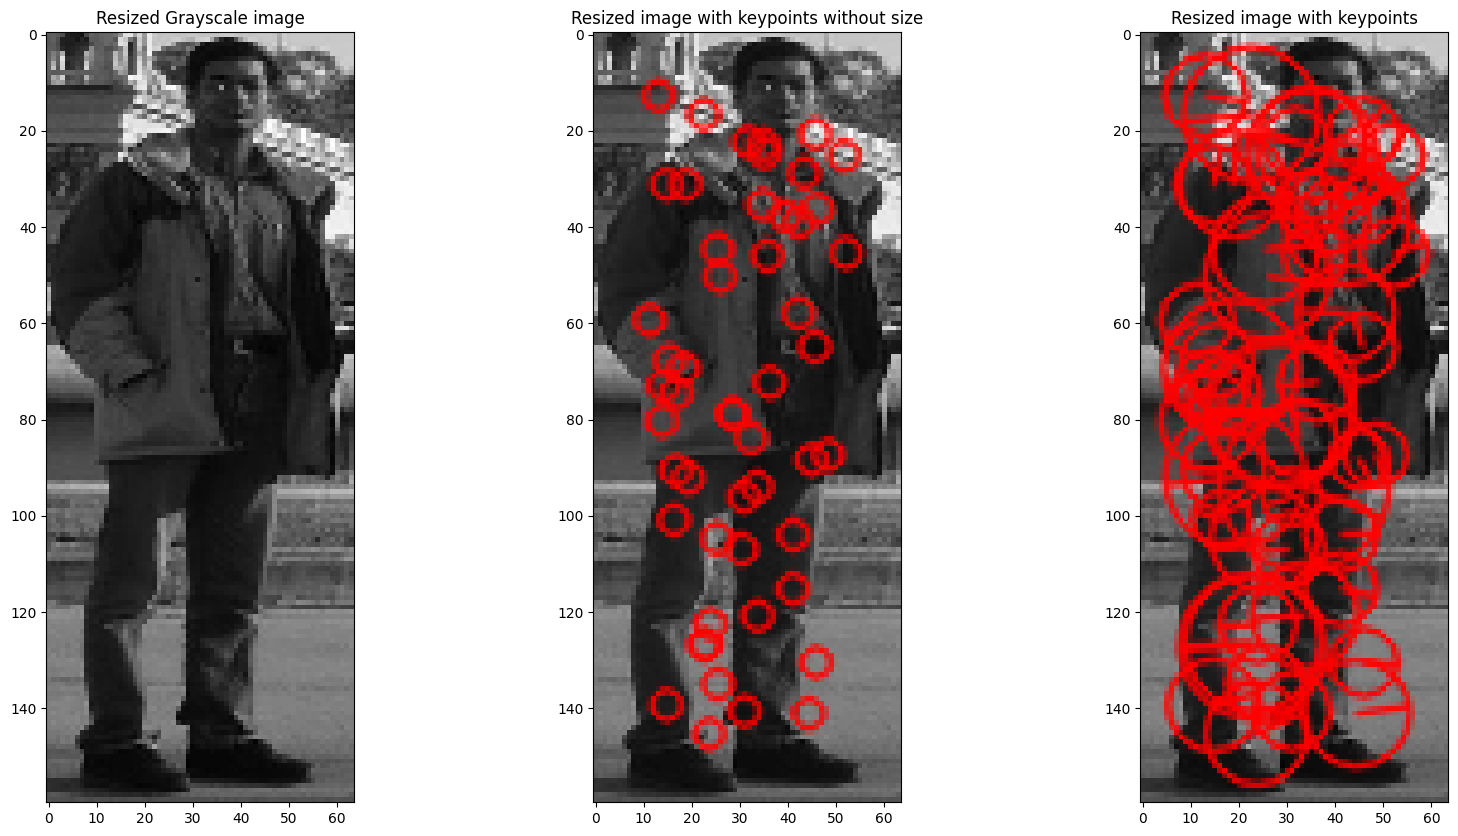

In [8]:
import cv2
import matplotlib.pyplot as plt
import os

test_image = cv2.cvtColor(cv2.imread(os.path.join('./media/test_image.png')), cv2.COLOR_BGR2RGB)
test_image_resized = cv2.resize(test_image, input_image_shape)
test_image_resized_gray = cv2.cvtColor(test_image_resized, cv2.COLOR_RGB2GRAY)

surf = cv2.xfeatures2d.SURF_create()

test_keypoints, test_descriptor = surf.detectAndCompute(test_image_resized_gray, None)

test_image_with_keypoints_size = cv2.drawKeypoints(test_image_resized_gray, test_keypoints, None, (255, 0, 0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
test_image_with_keypoints_without_size = cv2.drawKeypoints(test_image_resized_gray, test_keypoints, None, (255, 0, 0))

# Display image with and without keypoints size
fx, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))

ax1.set_title("Resized Grayscale image")
ax1.imshow(test_image_resized_gray, cmap=plt.cm.gray)

ax2.set_title("Resized image with keypoints without size")
ax2.imshow(test_image_with_keypoints_without_size)

ax3.set_title("Resized image with keypoints")
ax3.imshow(test_image_with_keypoints_size)


## Define SURF transformer

In [36]:
from sklearn.cluster import KMeans
import cv2
import numpy as np
from scipy.spatial.distance import cdist

class SURF_transformer():
    def __init__(self, hessianThreshold=100, n_clusters=50, vocab_size=1):
        self.surf = cv2.xfeatures2d.SURF_create(hessianThreshold)
        self.kMeans = KMeans(n_clusters=n_clusters)
        self.n_clusters = n_clusters
        self.vocab_size = vocab_size
    
    def create_vocab(self, X, vocab=None):
        if vocab is None:
            self.features = np.array([])
            for img in X:
                _, descriptor = self.surf.detectAndCompute(img, None)
                if type(descriptor) != type(None):
                    self.features = descriptor if len(self.features) == 0 else np.vstack((self.features, descriptor))
            indexes = np.random.choice(self.features.shape[0], int(self.features.shape[0]*self.vocab_size), replace=True)
            self.vocab = self.features[indexes]
        else:
            self.vocab = vocab
            
        self.kMeans.fit(self.vocab)
        return self.vocab
        
    def transform(self, X):
        list_histogram = []
        for img in X:
            _, descriptor = self.surf.detectAndCompute(img, None)
            
            if type(descriptor) != type(None):
                indexes = self.kMeans.predict(descriptor)
                histogram = np.bincount(indexes, minlength=self.n_clusters)
            else:
                histogram = np.zeros(self.n_clusters)

            list_histogram.append(histogram)
        return np.array(list_histogram), _
    

## Extract SURF features from datasets

In [45]:
resave = False

features_train, features_valid, features_test = [], [], []

if resave or not features_available('SURF') or not features_available('SURF_vocab', dataset_name_list=['train']):
    surf = SURF_transformer(hessianThreshold=0, n_clusters=400, vocab_size=1)
    vocab = surf.create_vocab(X_train)

    features_train, _ = surf.transform(X_train)
    features_valid, _ = surf.transform(X_valid)
    features_test, _ = surf.transform(X_test)

    save_features('SURF_vocab', 'train', vocab)
    save_features('SURF', 'train', features_train)
    save_features('SURF', 'valid', features_valid)
    save_features('SURF', 'test', features_test)

SURF_vocab = load_features('SURF_vocab', 'train')
features_train = load_features('SURF', 'train')
features_valid = load_features('SURF', 'valid')
features_test = load_features('SURF', 'test')

print(SURF_vocab.shape)
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(121745, 64)
(2124, 400)
(725, 400)
(361, 400)


## Train classifiers based on SURF Features

In [ ]:
from sklearn import svm
from sklearn.metrics import classification_report

svc_surf = svm.SVC()

svc_surf.fit(features_train, y_train)
y_pred = svc_surf.predict(features_test)

test_report = classification_report(y_test, y_pred)
print(test_report)

              precision    recall  f1-score   support

           0       0.92      0.69      0.79       186
           1       0.74      0.94      0.83       175

    accuracy                           0.81       361
   macro avg       0.83      0.81      0.81       361
weighted avg       0.83      0.81      0.81       361



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf_surf = RandomForestClassifier()

rf_surf.fit(features_train, y_train)
y_pred = rf_surf.predict(features_test)

test_report = classification_report(y_test, y_pred)
print(test_report)

              precision    recall  f1-score   support

           0       0.89      0.67      0.76       186
           1       0.72      0.91      0.81       175

    accuracy                           0.79       361
   macro avg       0.81      0.79      0.78       361
weighted avg       0.81      0.79      0.78       361



# Real-time pedestrian detection

## Define pedestrian detection machine

In [64]:
class Pedestrian_detection_machine:
    def __init__(self, initial_box_size, overlap_ratio_threshold, scale, shift_size):
        self.initial_box_size = initial_box_size
        self.overlap_ratio_threshold = overlap_ratio_threshold
        self.scale = scale
        self.shift_size = shift_size
    
    def load_model(self, classifier_name, features_extraction_technique):
        if features_extraction_technique == 'HOG':
            self.transformer = HOG_transfomer()
            if classifier_name == 'SVM':
                self.model = svc_hog
            elif classifier_name == 'Random Forest':
                self.model = rf_hog
        elif features_extraction_technique == 'XCS-LBP':
            self.transformer = XCS_LBP_transformer()
            if classifier_name == 'SVM':
                self.model = svc_xcs_lbp
            elif classifier_name == 'Random Forest':
                self.model = rf_xcs_lbp
        elif features_extraction_technique == 'LBP':
            self.transformer = LBP_transformer()
            if classifier_name == 'SVM':
                self.model = svc_lbp
            elif classifier_name == 'Random Forest':
                self.model = rf_lbp
        elif features_extraction_technique == 'SURF':
            self.transformer = SURF_transformer(hessianThreshold=0, n_clusters=400, vocab_size=1)
            self.transformer.create_vocab(X_train, vocab=SURF_vocab)
            if classifier_name == 'SVM':
                self.model = svc_surf
            elif classifier_name == 'Random Forest':
                self.model = rf_surf

    def detect(self, image):
        (image_height, image_width) = image.shape
        box_size = self.initial_box_size
        box_positions = []
        while box_size[0] <= image_width and box_size[1] <= image_height:
            top_left_index = (0, 0)
            bottom_right_index = (top_left_index[0] + box_size[0], top_left_index[1] + box_size[1])
            while bottom_right_index[0] <= image_width and bottom_right_index[1] <= image_height:
                try:
                    cropped_image = image[top_left_index[1]:bottom_right_index[1], top_left_index[0]:bottom_right_index[0]]
                except:
                    x = 1
                features, _ = self.transformer.transform([cropped_image])
                prediction = self.model.predict([features[0]])
                if prediction[0] == 1:
                    if self._accept_box(top_left_index, bottom_right_index, box_positions):
                        box_positions.append((top_left_index, bottom_right_index))
                bottom_right_index = self._shift_coordinate(bottom_right_index, 'right')
                if bottom_right_index[0] <= image_width:
                    top_left_index = self._shift_coordinate(top_left_index, 'right')
                else:
                    top_left_index = self._shift_coordinate(top_left_index, 'down')
                    top_left_index = (0, top_left_index[1])
                    bottom_right_index = (top_left_index[0] + box_size[0], top_left_index[1] + box_size[1])
            box_size = (box_size[0] * self.scale, box_size[1] * self.scale)

        return box_positions
    
    def _shift_coordinate(self, coordinate, direction):
        if direction == 'right':
            return (coordinate[0] + self.shift_size, coordinate[1])
        if direction == 'down':
            return (coordinate[0], coordinate[1] + self.shift_size)

    def _accept_box(self, top_left_index, bottom_right_index, box_positions):
        for box_position in box_positions:
            ((x1, y1), (x2, y2)) = box_position
            ((x3, y3), (x4, y4)) = (top_left_index, bottom_right_index)

            overlap_left = max(x1, x3)
            overlap_right = min(x2, x4)
            overlap_top = max(y1, y3)
            overlap_bottom = min(y2, y4)
            
            overlap_width = max(0, overlap_right - overlap_left)
            overlap_height = max(0, overlap_bottom - overlap_top)

            overlap_area = overlap_width * overlap_height
            box_area = (x2-x1)*(y2-y1)
            if overlap_area > box_area * self.overlap_ratio_threshold:
                return False
        return True


## Detect test image with multiple objects

7


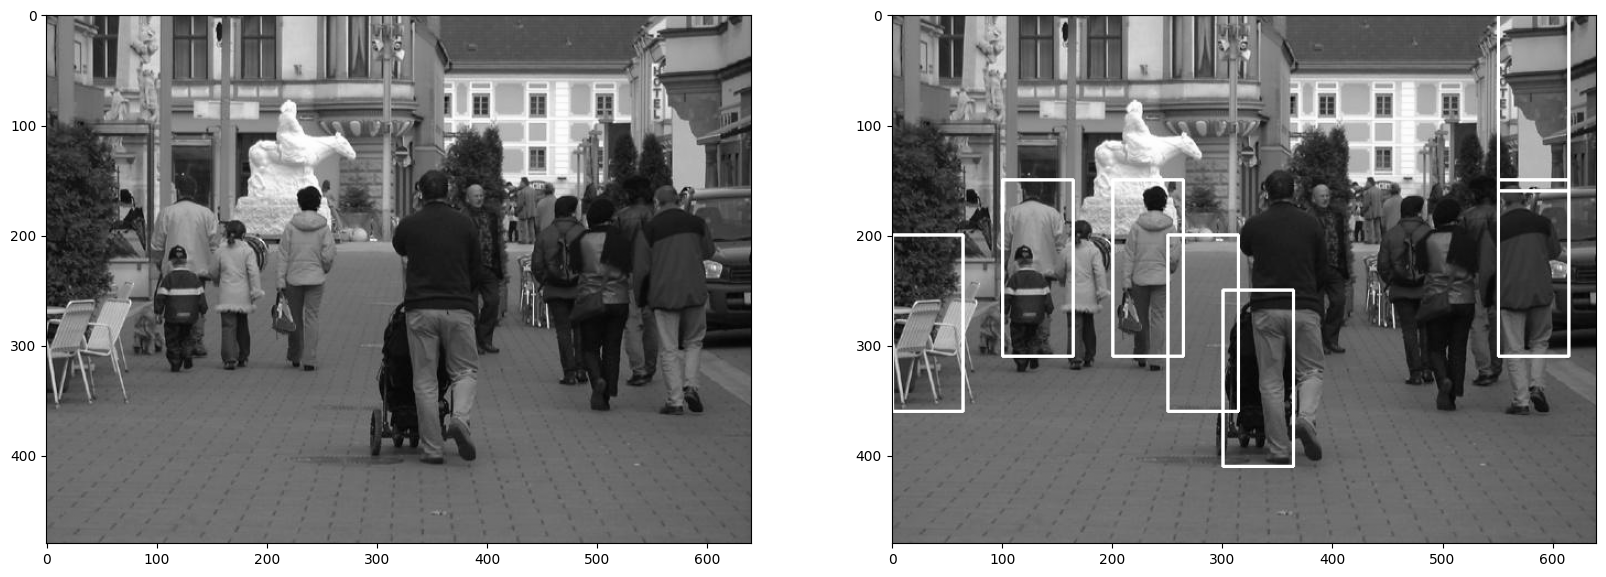

In [73]:
import cv2
import matplotlib.pyplot as plt

multi_object_image = cv2.cvtColor(cv2.imread('./media/multi_object_image.jpg'), cv2.COLOR_BGR2RGB)
multi_object_image_gray = cv2.cvtColor(multi_object_image, cv2.COLOR_RGB2GRAY)

detection_machine = Pedestrian_detection_machine(input_image_shape, overlap_ratio_threshold=1, scale=1.5, shift_size=50)
detection_machine.load_model('SVM', 'HOG')
prediction_boxes = detection_machine.detect(multi_object_image_gray)

detected_multi_object_image_gray = multi_object_image_gray.copy()

for prediction_box in prediction_boxes:
    detected_multi_object_image_gray = cv2.rectangle(detected_multi_object_image_gray, \
                                                    prediction_box[0], \
                                                    prediction_box[1], (255, 0, 0), 2)
print(len(prediction_boxes))
fx, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(multi_object_image_gray, cmap='gray')
ax2.imshow(detected_multi_object_image_gray, cmap='gray')

